Create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/ec2-user/geoseg/segment-anything/notebooks


conda create -n sam python=3.8 opencv=4.4.0 -c conda-forge

conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia

conda install jupyter

conda install matplotlib

conda install pandas

## Load Model

In [2]:
import torch

DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_b"

In [3]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-l49n24o7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-l49n24o7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '../weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

predictor = SamPredictor(sam)

## Upload Image(s)

In [5]:
from PIL import Image
import cv2
import numpy as np

def process_image(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Verify if the image is loaded
    if image is None:
        print(f'Could not open or find the image: {image_path}')
        return None
    
    # Convert the OpenCV image to a PIL Image for easier manipulation
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Calculate the 20% zoom parameters
    width, height = image_pil.size
    # new_width = width * 0.8
    # new_height = height * 0.8
    # left = (width - new_width) / 2
    # top = (height - new_height) / 2
    # right = (width + new_width) / 2
    # bottom = (height + new_height) / 2
    
    # Crop the center of the image to achieve the zoom effect
    # image_zoomed = image_pil.crop((left, top, right, bottom))
    
    # # Resize the image to 512x512
    # image_resized = image_zoomed.resize((512, 512), Image.Resampling.LANCZOS)
    
    # Convert back to OpenCV format
    image_final = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    
    return image_final

In [ ]:
import glob

# Path to the directory with images
imgs_path = '../imgs'

# Get a list of all jpeg files in the directory
imgs_files = glob.glob(os.path.join(imgs_path, '*.png'))

# Initialize an empty list to store the images
imgs = []

# Restrict how many
restrict = 0

# Loop over all files
for img_file in imgs_files:
    restrict += 1
    if restrict == 5:
        break
    # Read the image
    img = process_image(img_file)

    # Verify if the image is loaded
    if img is None:
        print(f'Could not open or find the image: {img_file}')
    else:
        # Get the dimensions of the image
        # height, width, channels = img.shape

        imgs.append(img)

print(f"Successfully loaded {len(imgs)} images from {imgs_path}")

Successfully loaded 10 images from ./prompt_imgs


Make sure we imported right by displaying an image

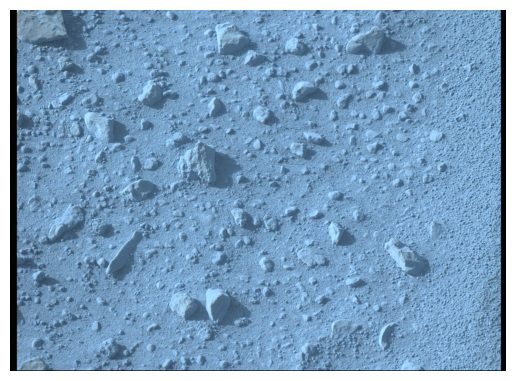

[array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 2, 13, 35],
        ...,
        [ 7,  3,  3],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [18, 18, 16],
        ...,
        [ 2,  2,  5],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8), array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(imgs[1])
plt.axis('off')  # Hide the axis
plt.show()
print(imgs)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [8]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

### Generate masks with SAM

In [9]:
import cv2

results = []
for i in range(len(imgs)):
  image = imgs[i]
  sam_result = mask_generator.generate(image)
  results.append(sam_result)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import json

save_path = '../dataset'
average_area = 0
total_segments = 0

# Function to calculate long and short axes from bbox
def calculate_axes(bbox):
    width, height = bbox[2], bbox[3]
    return max(width, height), min(width, height)

# Create the images and labels directories if not exist
os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(save_path, 'labels'), exist_ok=True)

for i in range(len(results)):
    img = imgs[i].copy()
    img_num = "{:03}".format(i)
    entry = {"img_num": img_num, "bboxes": [], "polygons": [], "areas": []}
    bboxes = []
    polygons = []
    areas = []
    contours_list = []

    for j, result in enumerate(results[i]):
        
        # Append area
        areas.append(result['area'])
        average_area += result['area']
        total_segments += 1

        # Append bbox and calculate axes
        bboxes.append(result['bbox'])
        # Process mask and find contours
        mask = (result['segmentation'] * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons += [cv2.approxPolyDP(contour, 1, True).tolist() for contour in contours]
        contours_list += contours

        # Optionally, draw contours on the image for visualization
        # cv2.drawContours(img, contours, -1, (0, 255, 0), 2)

    entry["bboxes"] = bboxes
    entry["polygons"] = polygons
    entry["areas"] = areas

    # Save the processed image
    img_path = os.path.join(save_path, 'images', f'{img_num}.png')
    cv2.imwrite(img_path, img)

    # Save the metadata as a JSON file
    json_path = os.path.join(save_path, 'labels', f'{img_num}.json')
    with open(json_path, 'w') as f:
        json.dump(entry, f)


In [11]:
import cv2
import numpy as np

def merge_contours_by_overlap(contours, overlap_threshold=0.5):
    merged_contours = []
    merged_areas = []
    used = set()

    for i, contour_i in enumerate(contours):
        if i in used:
            continue
        merged = contour_i
        for j, contour_j in enumerate(contours):
            if j in used or j == i:
                continue
            # Calculate the intersection and union areas
            intersection = cv2.intersectConvexConvex(contour_i, contour_j)[0]
            union = cv2.contourArea(contour_i) + cv2.contourArea(contour_j) - intersection
            # Calculate the overlap percentage
            overlap = intersection / union if union > 0 else 0
            # Merge if the overlap exceeds the threshold
            if overlap > overlap_threshold:
                merged = cv2.convexHull(np.vstack([merged, contour_j]))
                used.add(j)
                
        merged_contours.append(merged)
        merged_areas.append(cv2.contourArea(merged))
        used.add(i)
    
    return (merged_contours, merged_areas)

# Apply contour merging based on overlap
res = merge_contours_by_overlap([np.array(poly, np.int32) for poly in entry['polygons']])
merged_polygons = res[0]
merged_ares = res[1]
print(len(entry['polygons']), len(merged_polygons))  # Print the number of original and merged polygons


468 421


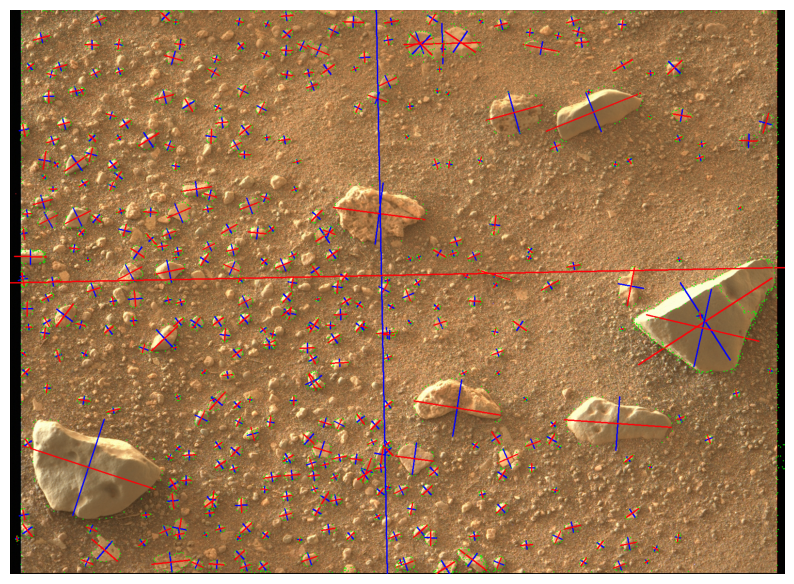

In [12]:
plt.figure(figsize=(10, 10))

# Convert image to RGB for matplotlib display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')

long_axes = []
short_axes = []
counted_areas = []
angles = []

# Loop through the segments to draw additional details
for result, bbox, polygon in zip(results[-1], entry['bboxes'], merged_polygons):
    
    # Ensure the polygon has at least 5 points
    if len(polygon) >= 5:
        # Fit an ellipse to the polygon and get its parameters
        poly_pts = np.array(polygon, np.int32).reshape((-1, 1, 2))
        ellipse = cv2.fitEllipse(poly_pts)
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        
        # Calculate the endpoints of the long and short axes
        angle_rad = np.radians(angle)
        cos_angle = np.cos(angle_rad)
        sin_angle = np.sin(angle_rad)
        
        half_major_axis = major_axis / 2
        half_minor_axis = minor_axis / 2
        short_axes.append(half_major_axis)
        long_axes.append(half_minor_axis)
        counted_areas.append(result['area'])
        
        start_long = (int(center_x - cos_angle * half_major_axis), int(center_y - sin_angle * half_major_axis))
        end_long = (int(center_x + cos_angle * half_major_axis), int(center_y + sin_angle * half_major_axis))
        
        start_short = (int(center_x + sin_angle * half_minor_axis), int(center_y - cos_angle * half_minor_axis))
        end_short = (int(center_x - sin_angle * half_minor_axis), int(center_y + cos_angle * half_minor_axis))
        
        # Draw the axes on the image with a smaller line width
        cv2.line(img_rgb, start_long, end_long, (0, 0, 255), 2)  # Red for long axis
        cv2.line(img_rgb, start_short, end_short, (255, 0, 9), 2)  # Blue for short axis
        
    # Optionally, draw simplified polygon contours with a thinner line
    for poly in polygon:
        pts = np.array(poly, np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 2)  # Smaller line width for the border

# Redisplay the image with the additional annotations
plt.imshow(img_rgb)
plt.show()


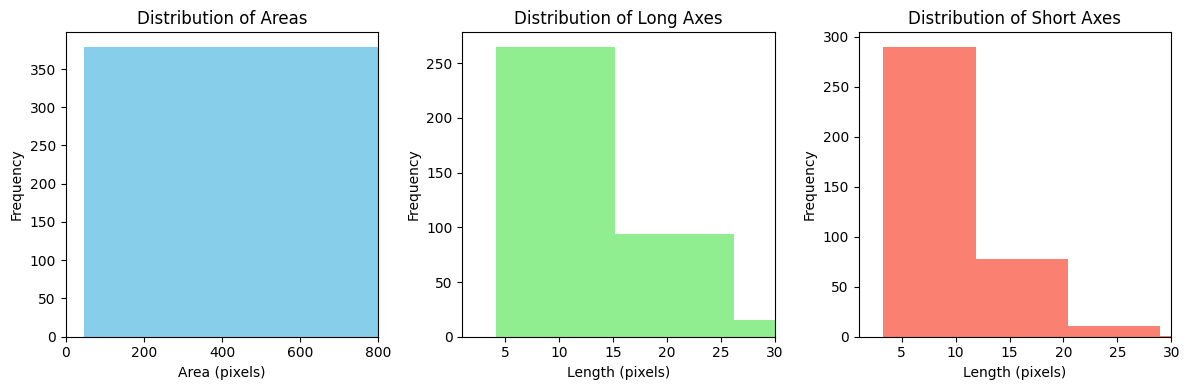

In [13]:
# Assuming you have collected 'areas', 'long_axes', and 'short_axes' data for all segments across images
# For demonstration, let's create some sample data

import numpy as np
import matplotlib.pyplot as plt

# Plotting the distribution of areas
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(counted_areas, bins=500, color='skyblue')
plt.title('Distribution of Areas')
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.xlim(0, 800)

# Plotting the distribution of long axes
plt.subplot(1, 3, 2)
plt.hist(long_axes, bins=80, color='lightgreen')
plt.title('Distribution of Long Axes')
plt.xlabel('Length (pixels)')
plt.ylabel('Frequency')
plt.xlim(1, 30)

# Plotting the distribution of short axes
plt.subplot(1, 3, 3)
plt.hist(short_axes, bins=80, color='salmon')
plt.title('Distribution of Short Axes')
plt.xlabel('Length (pixels)')
plt.ylabel('Frequency')
plt.xlim(1, 30)

plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Create a DataFrame from the series
data = pd.DataFrame({'Areas': counted_areas, 'Long Axes': long_axes, 'Short Axes': short_axes})

# Print summary statistics for all three
print(data.describe())


              Areas   Long Axes  Short Axes
count  3.900000e+02  390.000000  390.000000
mean   5.311662e+03   18.260427   12.935180
std    8.714500e+04   47.201091   35.745529
min    4.600000e+01    4.101138    3.297525
25%    2.095000e+02    9.445167    7.093452
50%    3.805000e+02   13.200355    9.620660
75%    5.527500e+02   16.368152   11.903861
max    1.720603e+06  888.123413  687.613953


/tmp/ipykernel_12028/2567759346.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
